In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib qt

#### Functions

In [15]:
# Calibrate the camera for the given horozontal and vertical grid points
# Look at all of the images in the given folder to calibrate the camera
# Returns:
#       - mtx, dist points used in cv2.calibrateCamera

def calibCamera(nX, nY, folderName):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nY*nX, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nX, 0:nY].T.reshape(-1, 2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(folderName+'/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nX, nY), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nX, nY), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
            
    #cv2.destroyAllWindows()
    # Test undistortion on an image
    img = cv2.imread('camera_cal/calibration5.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
            
    return mtx, dist

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # Get Image dims in the form of (h,w)
    #img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist    

#### Verify/validate the functions

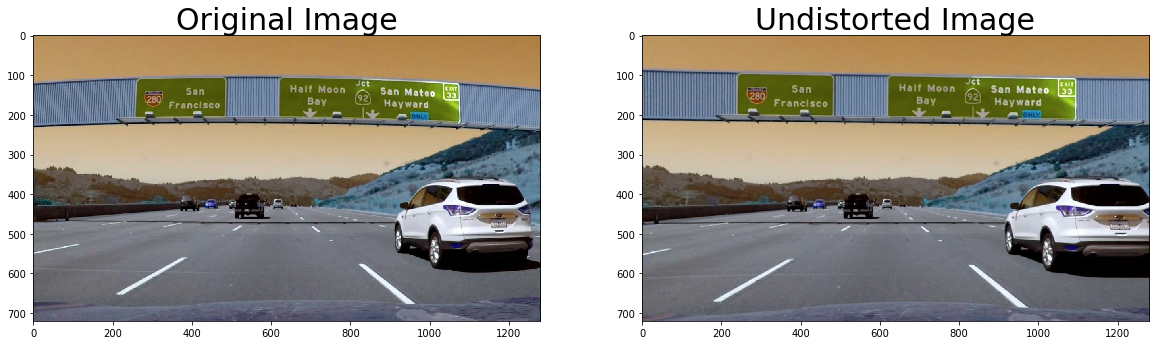

In [17]:
%matplotlib inline
mtx, dist  = calibCamera(9, 6, 'camera_cal')

# Test undistortion on an image
img = cv2.imread('camera_cal/signs_vehicles_xygrad.png')

dst = cal_undistort(img, mtx, dist)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
%matplotlib inline